In [24]:
# !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
from latexify import latexify
latexify(columns = 2)

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


In [26]:
from IPython.display import Audio
Audio('audio.wav')
import torchaudio
audio, sr = torchaudio.load('./audio.wav')

In [27]:
print(sr)
print(audio.shape)
audio = audio[0]
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")
print(audio)


48000
torch.Size([2, 309888])
Audio length: 6.456 seconds
tensor([0., 0., 0.,  ..., 0., 0., 0.])


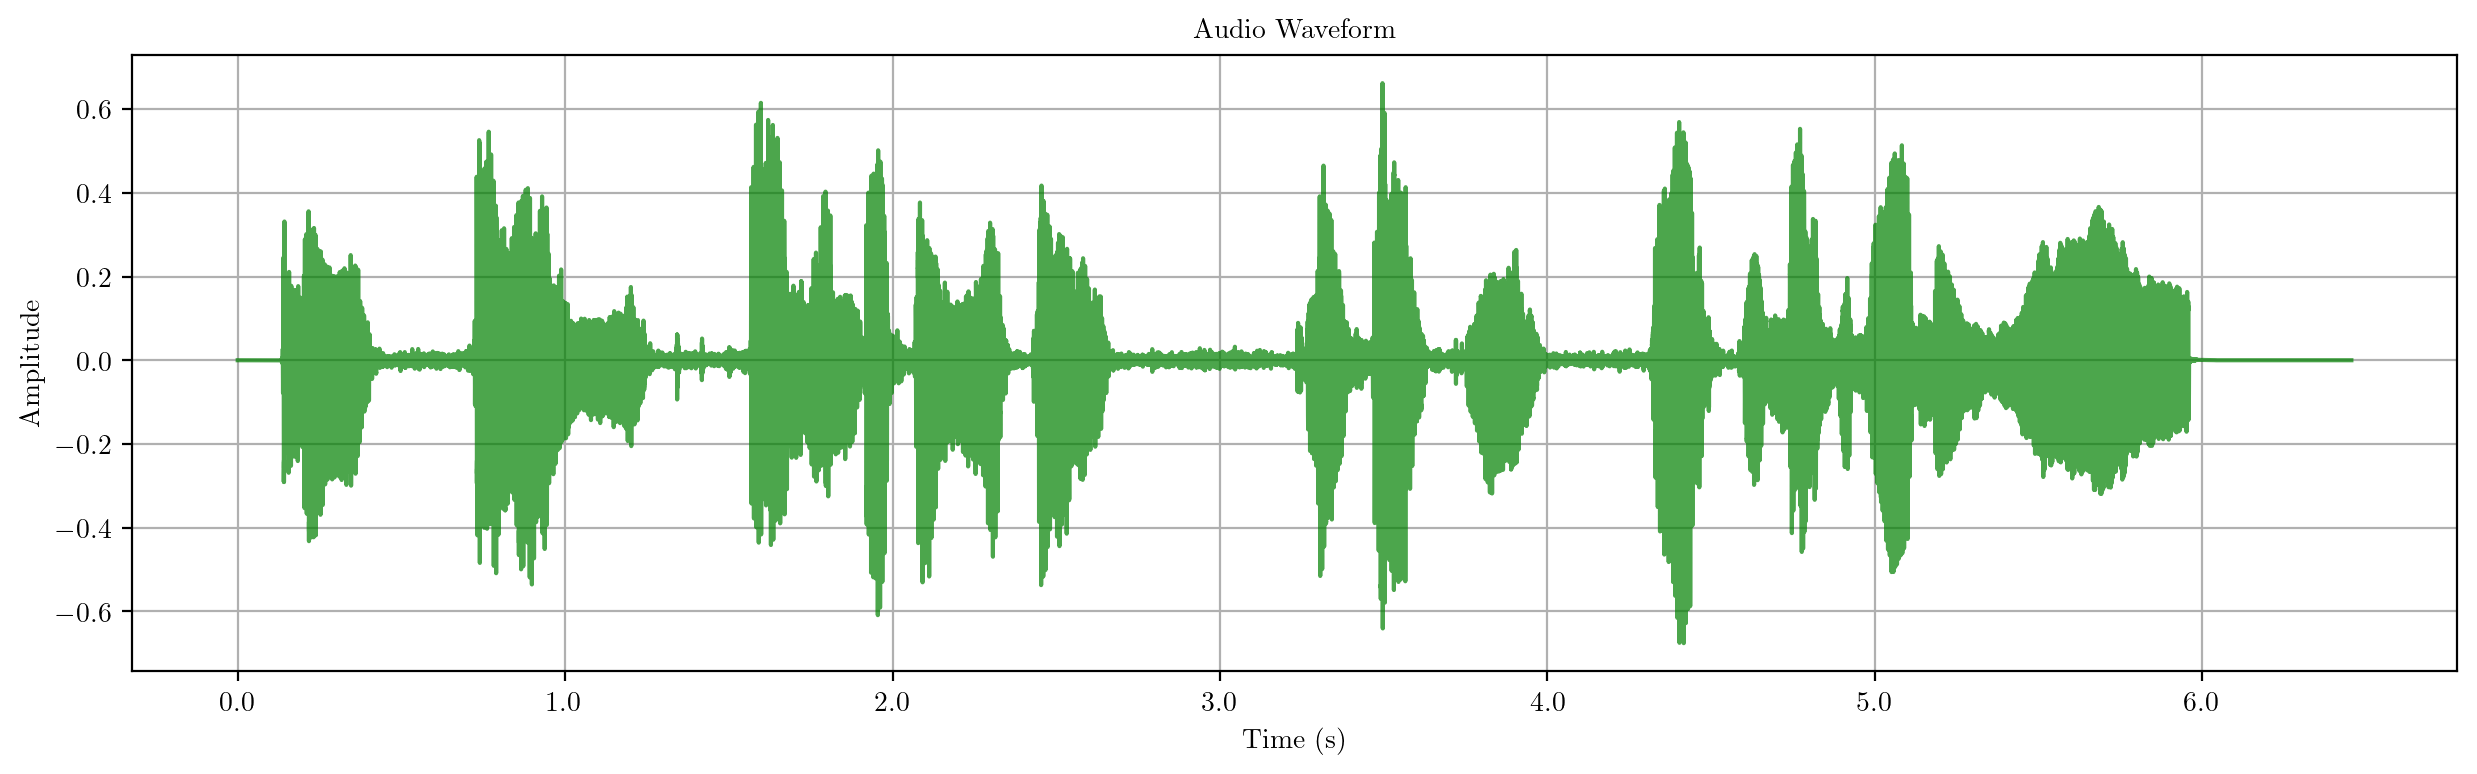

In [28]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()
audio_plot(audio, sr, 'green', 'Audio Waveform')

torch.Size([96000])
tensor([0.0514, 0.0450, 0.0426,  ..., 0.0000, 0.0000, 0.0000])


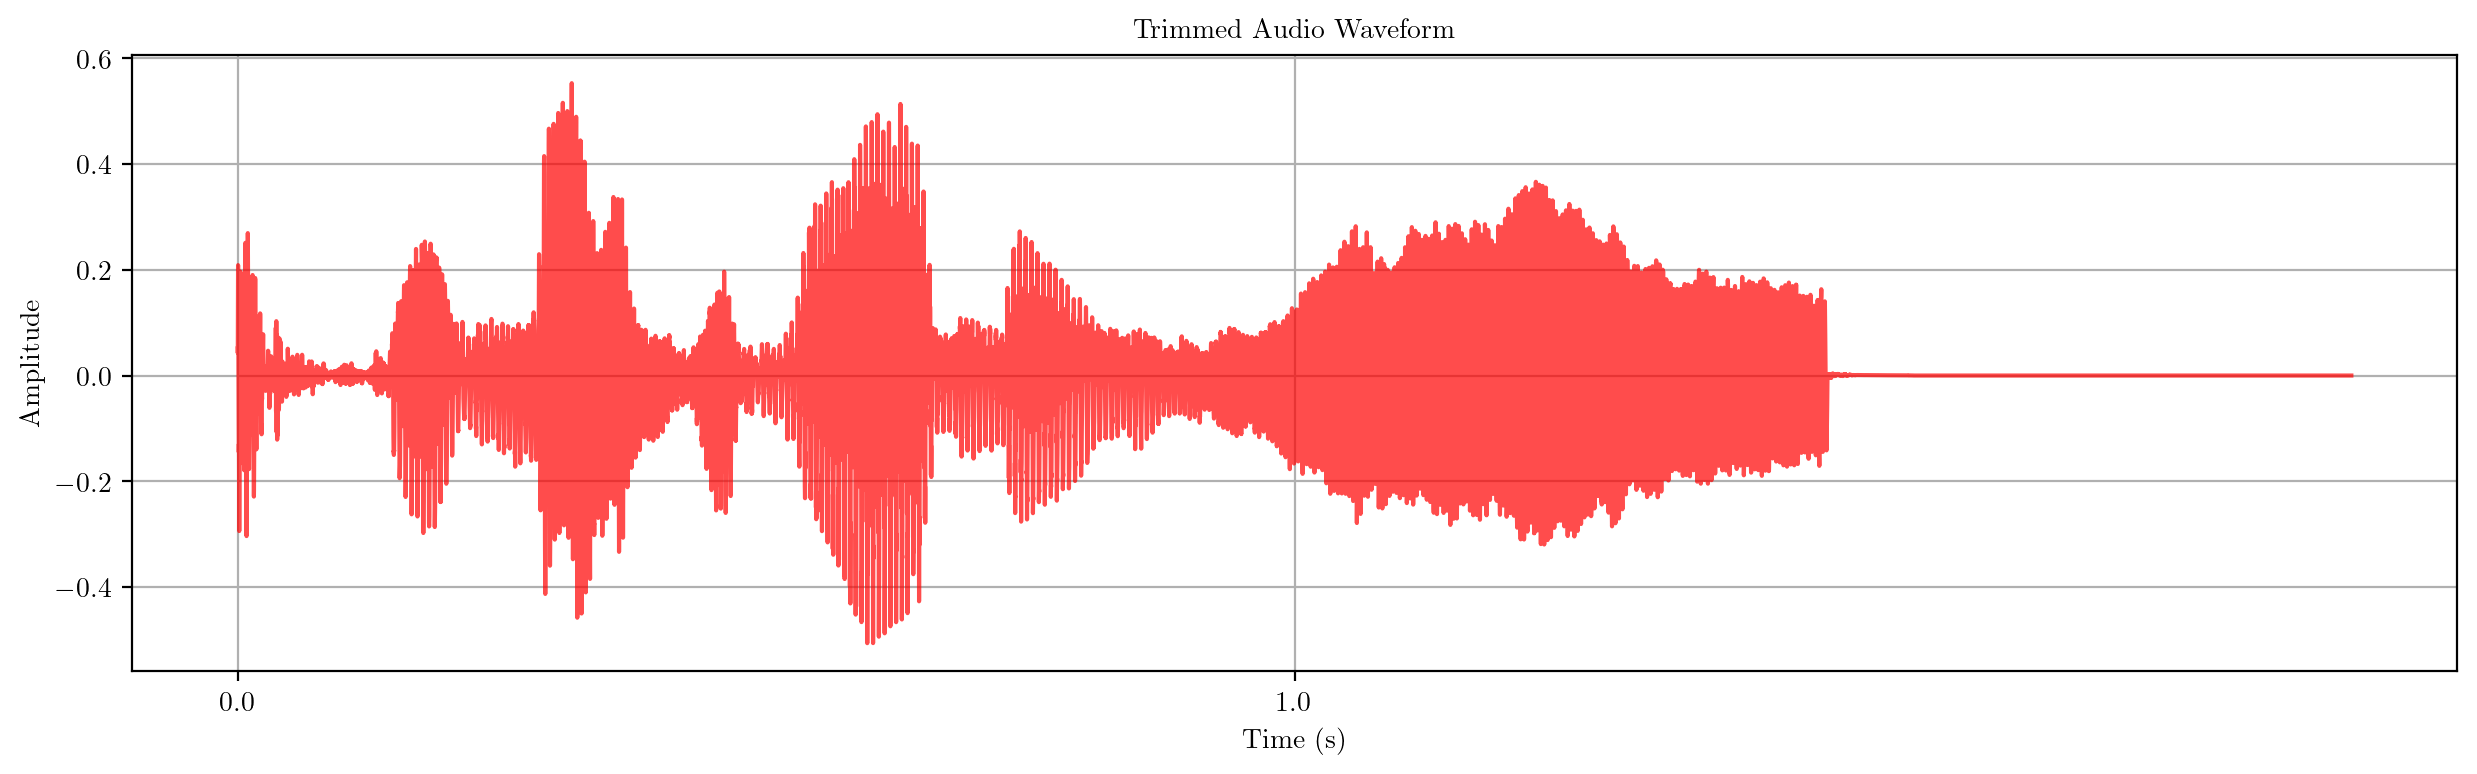

In [29]:
audio = audio[-2 * sr:]
print(audio.shape)
print(audio)
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

In [30]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([96000, 1])
tensor([[-100.0000],
        [ -99.9979],
        [ -99.9958],
        ...,
        [  99.9958],
        [  99.9979],
        [ 100.0000]])


In [31]:
Audio(audio, rate = sr)

In [32]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)


torch.Size([96000, 5000])
tensor([[ 0.0088, -0.0179, -0.0190,  ..., -0.0196,  0.0071, -0.0053],
        [ 0.0054, -0.0193, -0.0190,  ..., -0.0198,  0.0091, -0.0087],
        [ 0.0017, -0.0199, -0.0189,  ..., -0.0199,  0.0110, -0.0119],
        ...,
        [-0.0136, -0.0200, -0.0147,  ...,  0.0047, -0.0039, -0.0091],
        [-0.0107, -0.0195, -0.0146,  ...,  0.0058, -0.0017, -0.0121],
        [-0.0074, -0.0183, -0.0144,  ...,  0.0068,  0.0005, -0.0148]])


(96000,)
[-0.1202779  -0.09915247 -0.07891496 ...  0.12123571  0.12699506
  0.13290414]
tensor([0.0514, 0.0450, 0.0426,  ..., 0.0000, 0.0000, 0.0000])


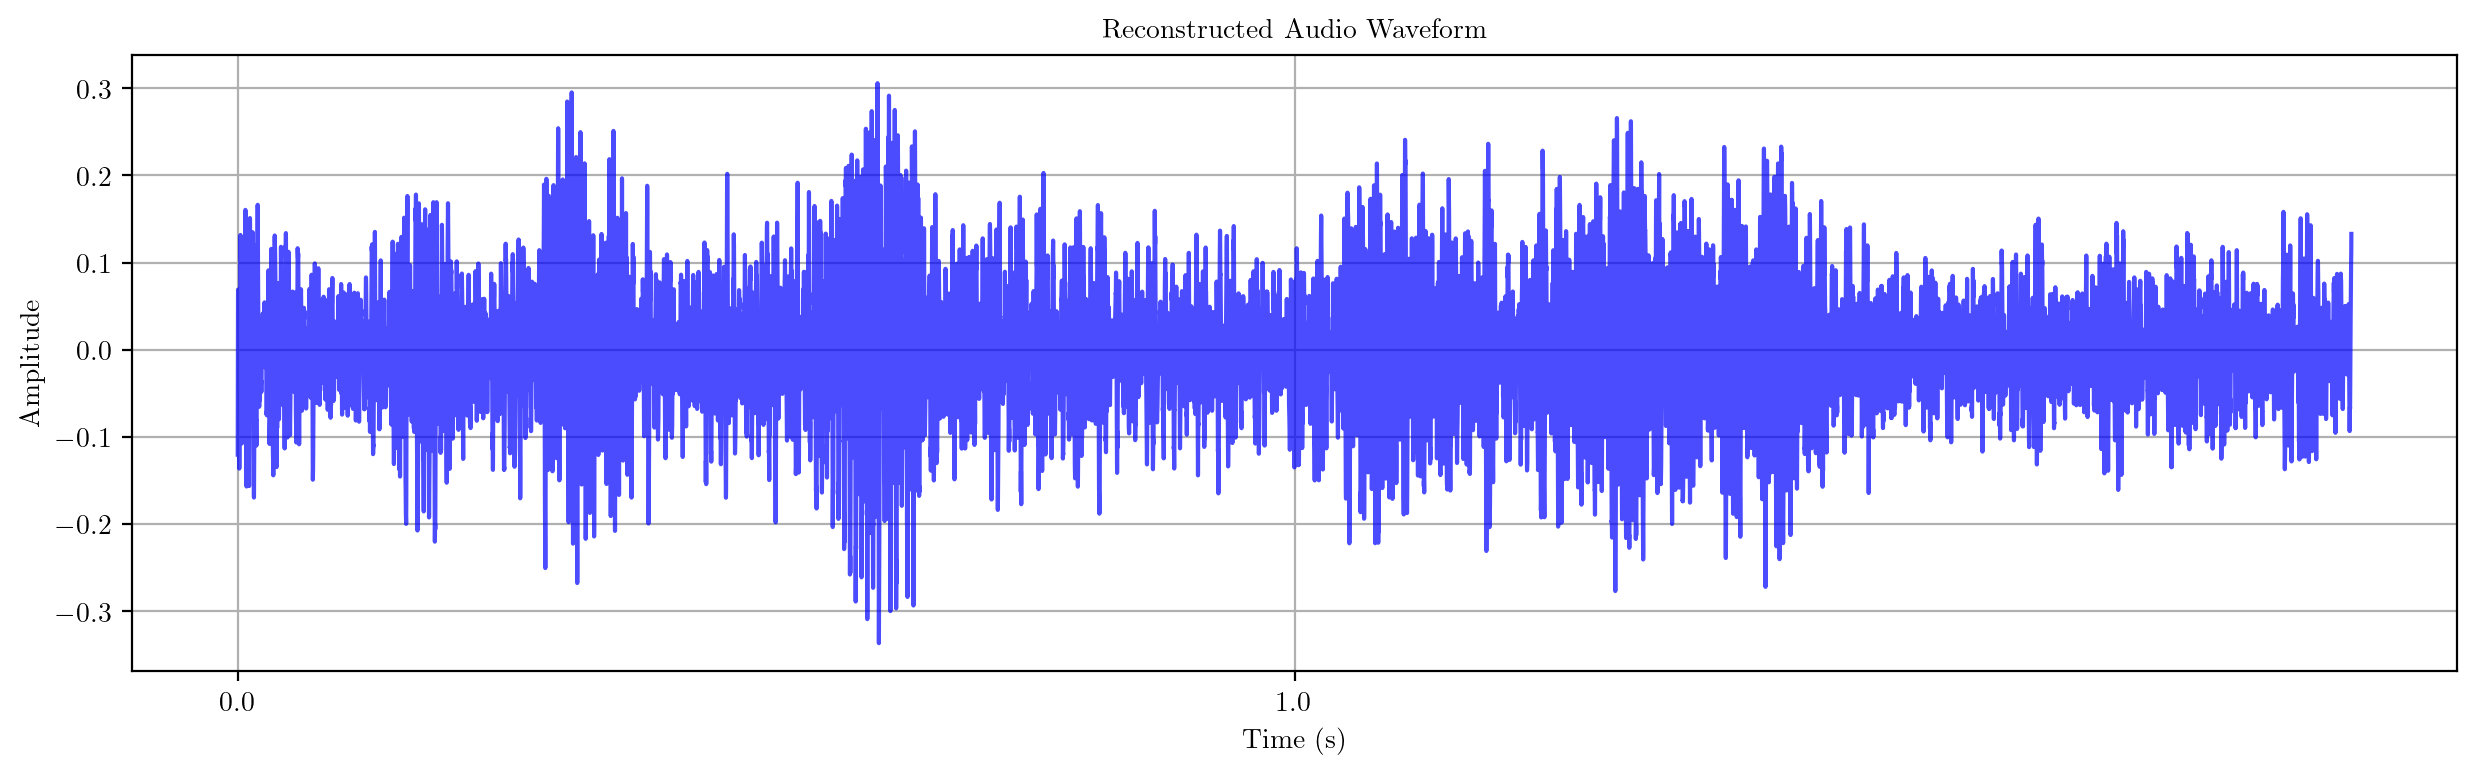

In [33]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)
print(pred_audio)
print(audio)
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)
Audio(pred_audio, rate = sr)

audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

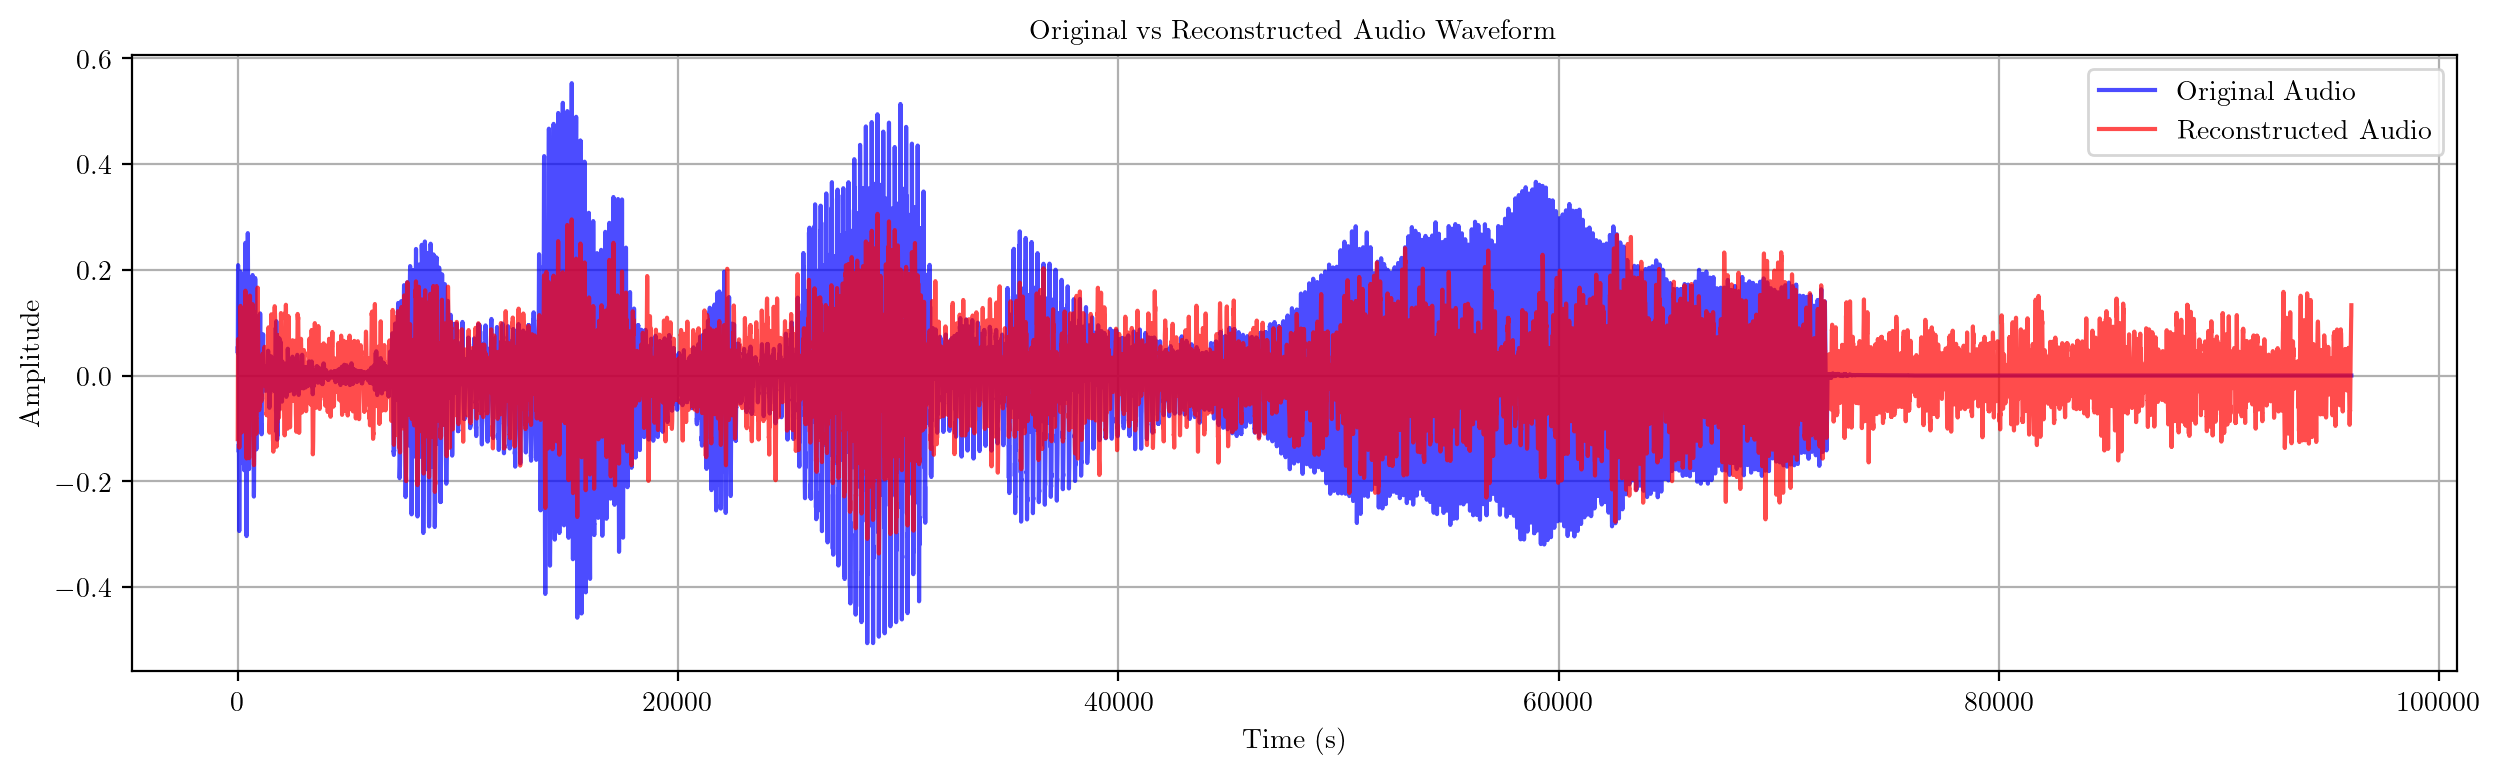

In [34]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [39]:
import numpy as np

# Function to calculate RMSE
def calculate_rmse(original, predicted):
    # Converting Torch Tensors to NumPy arrays for compatibility
    original = original.numpy()
    return np.sqrt(np.mean((original - predicted) ** 2))

# Function to calculate SNR
def calculate_snr(original, predicted):
    # Converting Torch Tensors to NumPy arrays for compatibility
    original = original.numpy()

    # Signal power
    signal_power = np.sum(original ** 2)
    # Noise power (difference between original and predicted)
    noise_power = np.sum((original - predicted) ** 2)
    # SNR calculation in decibels (dB)
    return 10 * np.log10(signal_power / noise_power)

# Ensure both audio signals have the same length (in case of mismatch)
pred_audio = pred_audio[:len(audio)]

# Calculate RMSE
rmse = calculate_rmse(audio, pred_audio)
print(f"RMSE: {rmse}")

# Calculate SNR
snr = calculate_snr(audio, pred_audio)
print(f"SNR: {snr} dB")



RMSE: 0.07711271941661835
SNR: 3.054170310497284 dB
